In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import wandb
import hydra
import omegaconf
from omegaconf import DictConfig, OmegaConf
import os

import sklearn
from sklearn.datasets import make_moons
from sfm.distributions import get_source_distribution



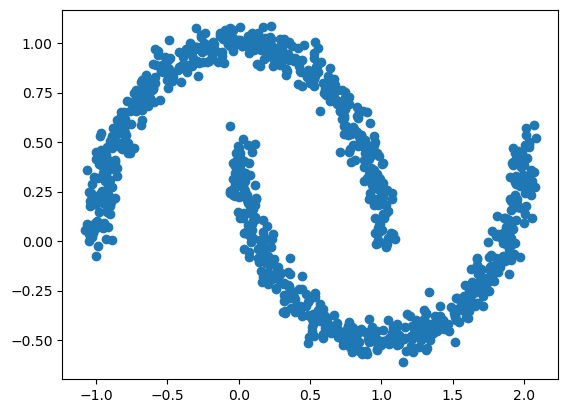

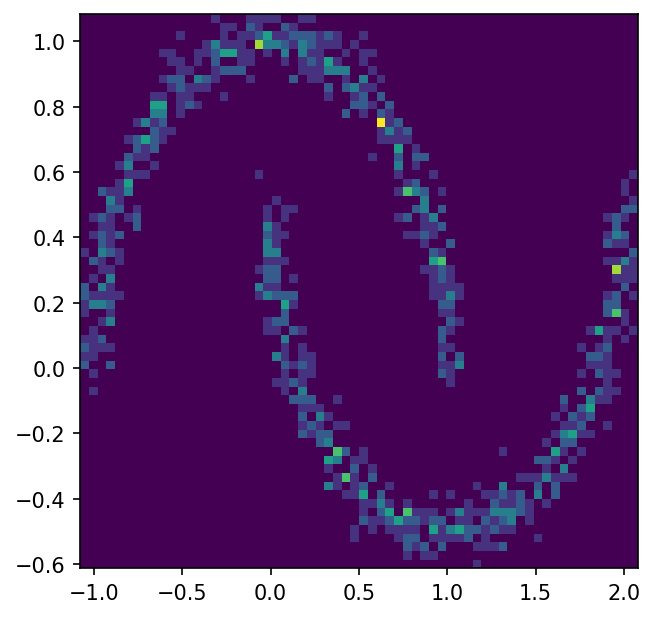

In [3]:
n_samples = 1000
datanoise = 0.05
data, _ = make_moons(n_samples, noise=datanoise)
data = torch.from_numpy(data).float()

plt.scatter(data[:, 0], data[:, 1])
plt.show()

if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
plt.figure(figsize=(4.8, 4.8), dpi=150)
plt.hist2d(*data.T, bins=64)
plt.show()

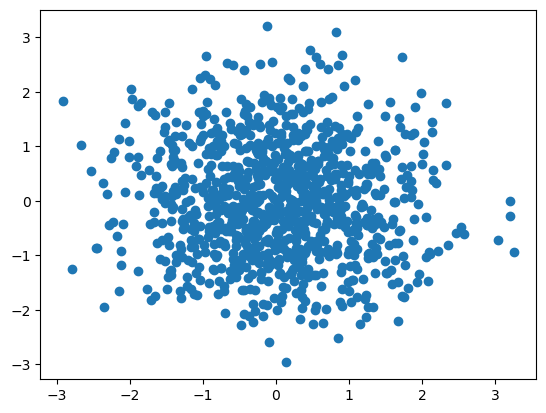

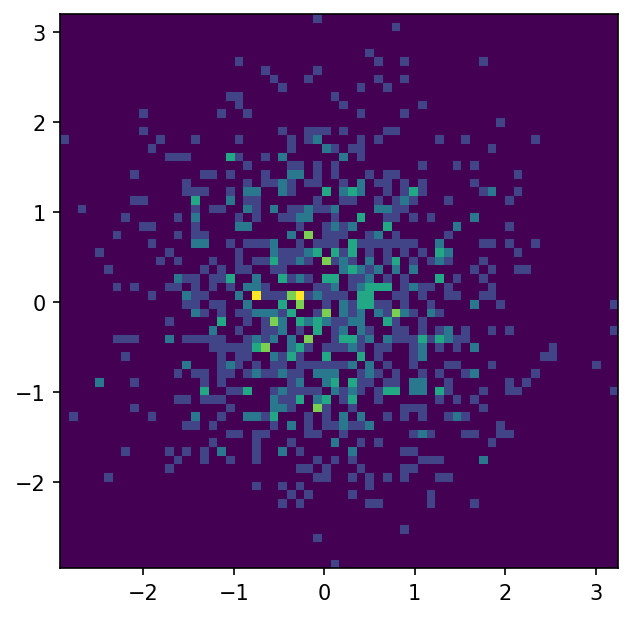

In [4]:

dist = get_source_distribution("normal")
samples = dist.sample(1000)

plt.scatter(samples[:, 0], samples[:, 1])
plt.show()

if isinstance(samples, torch.Tensor):
    samples = samples.cpu().numpy()
plt.figure(figsize=(4.8, 4.8), dpi=150)
plt.hist2d(*samples.T, bins=64)
plt.show()


In [5]:
def plot_dist(n_samples=1000, **kwargs):
    dist = get_source_distribution(**kwargs)
    samples = dist.sample(n_samples)

    plt.scatter(samples[:, 0], samples[:, 1])
    plt.show()

    if isinstance(samples, torch.Tensor):
        samples = samples.cpu().numpy()
    plt.figure(figsize=(4.8, 4.8), dpi=150)
    plt.hist2d(*samples.T, bins=64)
    plt.show()

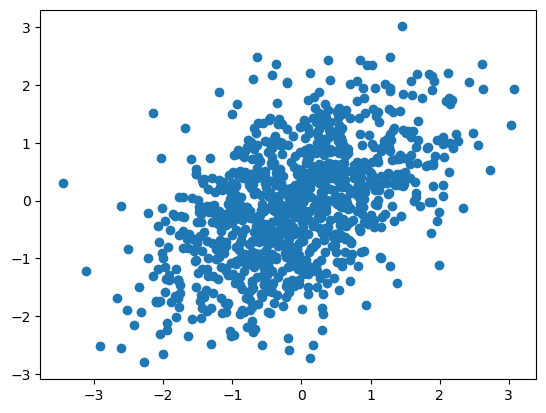

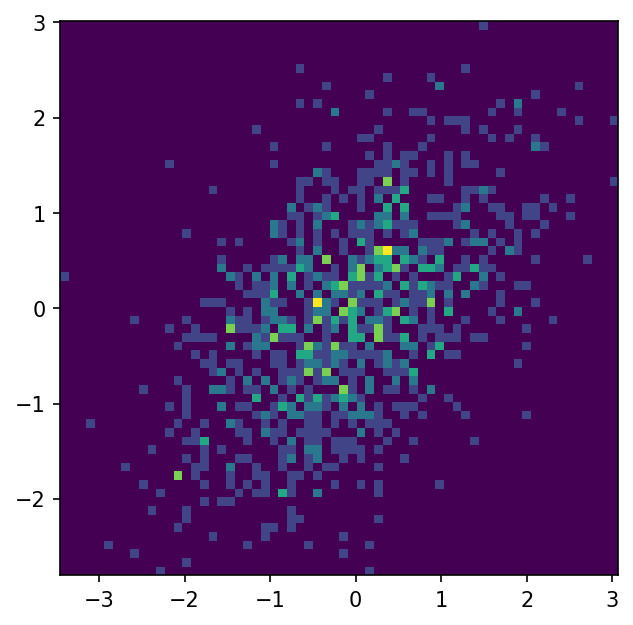

In [6]:
plot_dist(
    n_samples=1000,
    **{"type": "gaussian", "mu": torch.tensor([0.0, 0.0]), "Sigma": torch.tensor([[1.0, 0.5], [0.5, 1.0]])},
)


In [7]:
plot_dist(
    n_samples=1000,
    **{
        "type": "mog",
        "mus": [torch.tensor([0.0, 0.0]), torch.tensor([5.0, 5.0])],
        "sigmas": [torch.tensor([1.0, 1.0]), torch.tensor([1.0, 1.0])],
        "pis": [0.5, 0.5],
    },
)

ValueError: Input arguments must all be instances of numbers.Number, torch.Tensor or objects implementing __torch_function__.

In [8]:
sigma = torch.tensor([1.0, 0.5])
print(
    torch.diag(sigma)
)
dist = get_source_distribution(
    type="diagonal",
    mu=torch.tensor([0.0, 0.0]),
    sigma=sigma,
)


tensor([[1.0000, 0.0000],
        [0.0000, 0.5000]])


In [10]:
m = torch.distributions.Wishart(torch.Tensor([2]), covariance_matrix=torch.eye(2))
m = torch.distributions.Wishart(torch.Tensor([2]), covariance_matrix=torch.tensor([1.0, 2.0]))
samples = m.sample()
print(samples)




ValueError: scale_tril must be at least two-dimensional, with optional leading batch dimensions